# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# CUQI library imports
import cuqi
from cuqi.model import Model
from cuqi.distribution import Gaussian, Uniform, JointDistribution
from cuqi.sampler import MH, NUTS
from cuqi.geometry import Continuous1D, Discrete

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 


#### Decide sample to use for experimental data

In [2]:
sample = 10 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([1.0, 0.0, 0.0]),
        np.array([0.0, 0.25, 0.0]),
        np.array([-1.0, 0.25, 0.0]),
        np.array([0.0, -0.25, 0.0]),
        np.array([-1.0, -0.25, 0.0])
    ],
    'bounds': ([-2., -2., -2.], [2., 2., 2.]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-3
}

noise = (NOISE_PARAMS['noise_factor'])**2


#### Load Surrogate Models

In [4]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

model_II = NN_Model()
model_II.load_model(data_processor_II.config['MODEL_PATH'])  # Ensure this uses data_processor_II

# Define forward and gradient functions for the first configuration
forward_model = create_forward_model_function(data_processor_I, model_I)
gradient_model = create_gradient_function(data_processor_I, model_I)

# Create a CUQI model using the forward model and gradient functions
cuqi_model = Model(forward=forward_model, 
                   jacobian=gradient_model,
                   range_geometry=Continuous1D(len(data_processor_I.time)),
                   domain_geometry=Discrete(["Overetch", "Offset", "Thickness"]))

# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test



In [5]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

# Generate observed data by adding Gaussian noise to the true data
y_observed = Gaussian(mean=y_true, cov=noise * np.eye(len(data_processor_I.time))).sample()

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = Uniform(low=np.array([-2., -2., -2.]), high=np.array([2.0, 2.0, 2.0]))

# Define the likelihood distribution for the output
# Gaussian distribution centered around the model's predictions with specified noise
y_distribution = Gaussian(mean=cuqi_model(x_distribution), cov=noise * np.eye(len(data_processor_I.time)))
          

#### Perform least square optimization for each starting point

In [6]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.43694354 -1.49379948  0.24508136]
Optimized Params 1: [ 0.16850513 -1.41263286 -0.2184658 ]
Optimized Params 2: [ 0.14091359 -1.38913228  0.38581399]
Optimized Params 3: [ 0.05598702 -1.36170696  0.34634994]
Optimized Params 4: [ 0.22944529 -1.42541425  0.11448555]
Optimized Params 5: [ 0.08270729 -1.37280028  0.24547023]


#### Do Metropolis Hastings Sampling

In [8]:
# Define the covariance matrix for the Markov chain sampling, scaled by the noise factor
cov_matrix = covariance_matrix

# Set up the posterior distribution by combining the prior (x_distribution)
# and the likelihood (y_distribution) given the observed data (y_observed)
posterior = JointDistribution(x_distribution, y_distribution)(y_distribution=y_observed)

# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []

# Iterate over each initial guess to set up and run the Markov chain sampler
for index, initial_guess in enumerate(initial_guesses):
    # Set up the Markov chain sampler with the posterior, covariance matrix, and initial guessi
    proposal = Gaussian(mean=np.zeros(3), cov=cov_matrix*0.001)
    mc_sampler =  MH(target=posterior, proposal=proposal, x0=initial_guess)
    samples = mc_sampler.sample_adapt(MCMC_SETTINGS['N'], 0)  # Assuming 'N' is the number of samples desired
    
    # Append the samples to the list
    samples_mh.append(samples)
    
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", samples_mh[index].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt']).compute_ess(),"\n")

# Computing diagnostics and collecting results
print("Rhat: ", samples_mh[0].compute_rhat(samples_mh[1:]))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, samples_mh[0].samples)  

Sample 6000 / 6000

Average acceptance rate: 0.284 MCMC scale: 0.13456914421961913 

Effective Sample Size:  [ 99.45021089 132.9594468    8.01343307] 

Sample 6000 / 6000

Average acceptance rate: 0.2813333333333333 MCMC scale: 0.13231114212472975 

Effective Sample Size:  [17.28716787 65.05678784  2.48749777] 

Sample 6000 / 6000

Average acceptance rate: 0.294 MCMC scale: 0.14135885400093942 

Effective Sample Size:  [ 81.02398535 128.76771006   2.98439249] 

Sample 6000 / 6000

Average acceptance rate: 0.2911666666666667 MCMC scale: 0.137053730186248 

Effective Sample Size:  [ 6.13947566 79.89656728  3.24511848] 

Sample 6000 / 6000

Average acceptance rate: 0.2811666666666667 MCMC scale: 0.13494950901458572 

Effective Sample Size:  [ 20.56218104 119.58650749   6.85405263] 

Rhat:  [1.11072362 1.03542558 1.57393782]


Let's look at the trace plot of one chain

array([[<Axes: title={'center': 'Overetch'}>,
        <Axes: title={'center': 'Overetch'}>],
       [<Axes: title={'center': 'Offset'}>,
        <Axes: title={'center': 'Offset'}>],
       [<Axes: title={'center': 'Thickness'}>,
        <Axes: title={'center': 'Thickness'}>]], dtype=object)

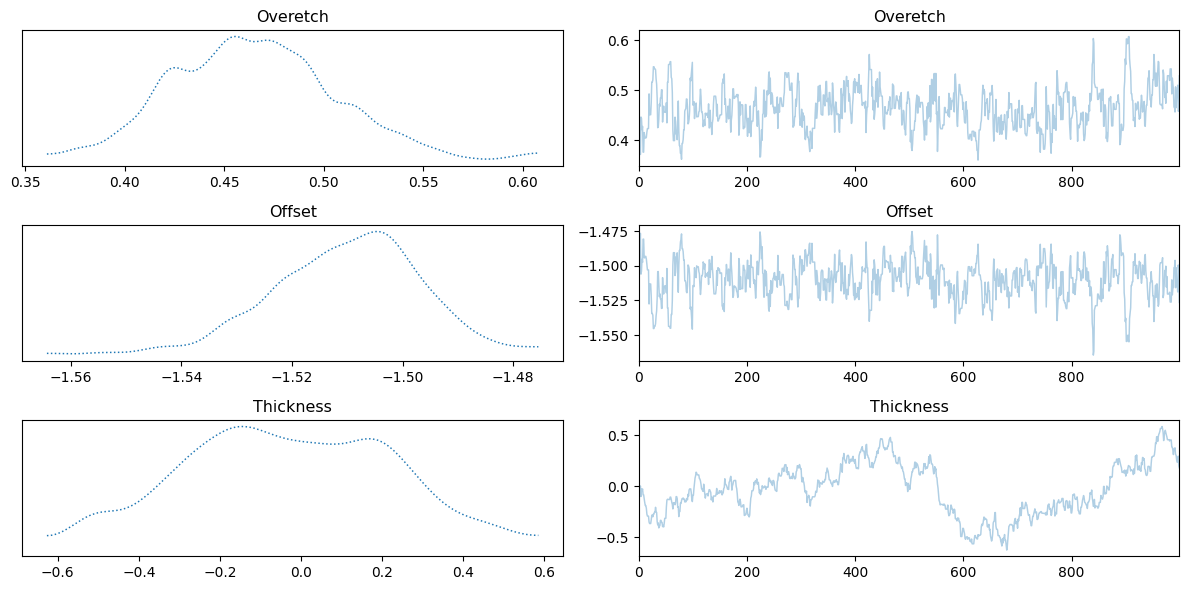

In [9]:
# Plot trace of the first set of samples
samples_mh[0].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt']).plot_trace()

Let's compare the prediction of the mean parameter combination and the experimental signal

In [10]:
print(y_observed)

[0.23522539 0.23392853 0.23169158 0.23561961 0.23381229 0.23436316
 0.2370864  0.23483434 0.23420315 0.23517234 0.23520841 0.23607875
 0.23496735 0.23650537 0.23706333 0.23726554 0.23799941 0.24013791
 0.24266643 0.24391257 0.24428568 0.24565466 0.2455174  0.24558522
 0.24813962 0.2487652  0.25085832 0.25050305 0.25112898 0.25223682
 0.24921861 0.2499376  0.2476882  0.24797516 0.24729596 0.24692643
 0.24396818 0.24254125 0.24307714 0.24316802 0.24013929 0.23949438
 0.24008948 0.23866449 0.23875583 0.2366459  0.23653812 0.23638478
 0.23549043 0.23643942 0.23727127 0.2372836  0.23598851 0.23784204
 0.23644743 0.2375961  0.23771001 0.23993619 0.24041804 0.24163763
 0.24394053 0.24558964 0.24440966 0.24774681 0.24804201 0.25033156
 0.25075193 0.25173085 0.24991881 0.24998292 0.25166082 0.2506354
 0.24972629 0.24966681 0.24665078 0.24783291 0.24400154 0.24257414
 0.24313411 0.24169485 0.2414091  0.23865451 0.23829743 0.23757132
 0.23856155 0.23861539 0.23833214 0.23798881 0.23523744 0.23710

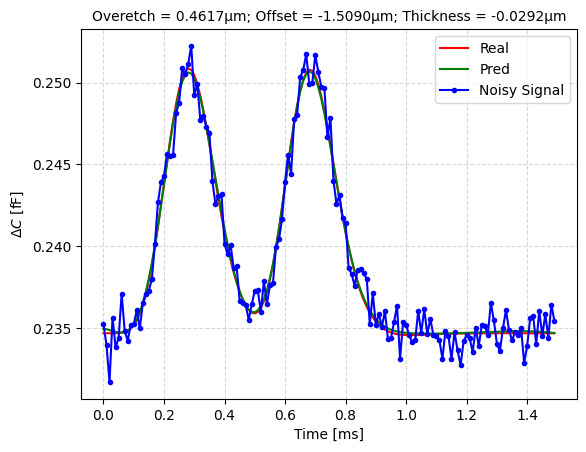

In [11]:
# Plotting and data collection
plot_results(data_processor_I.time, y_true, y_observed, forward_model, samples_mh[0])


Finally, let's look at the parameters distribution

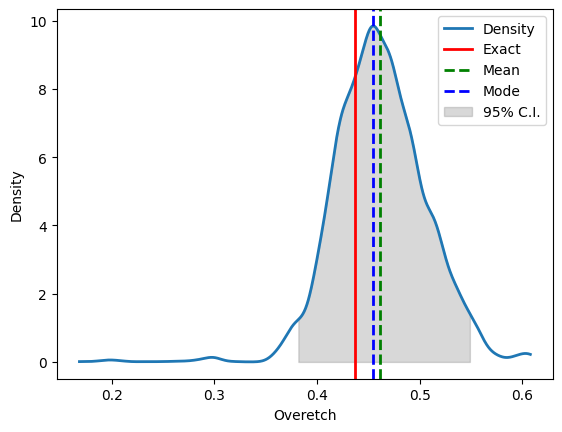

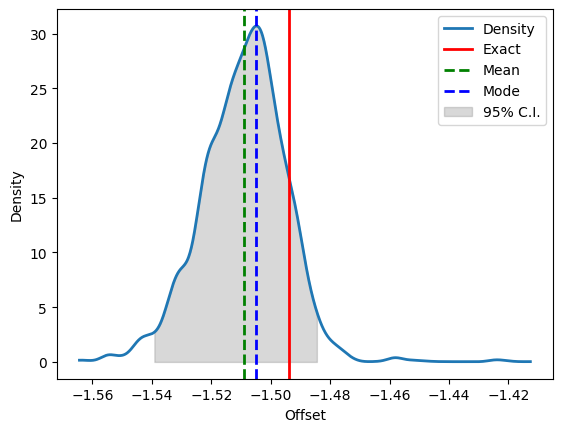

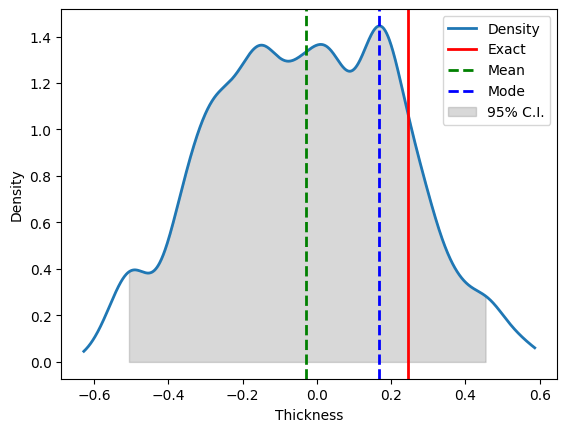

In [12]:
for j in range(3):
    plot_parameter_distribution(samples_mh[0].samples[j, :], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [13]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

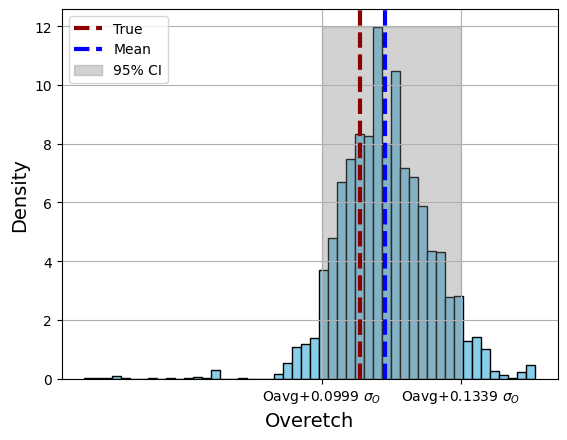

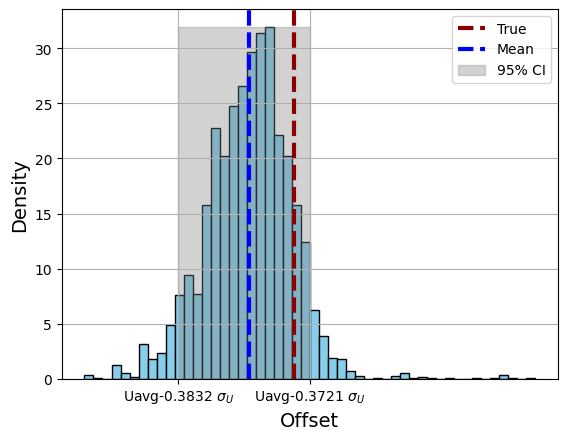

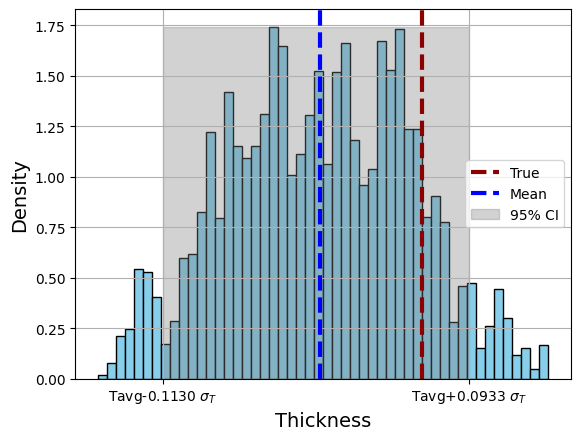

In [14]:
plot_histograms(samples, x_true)

ciao


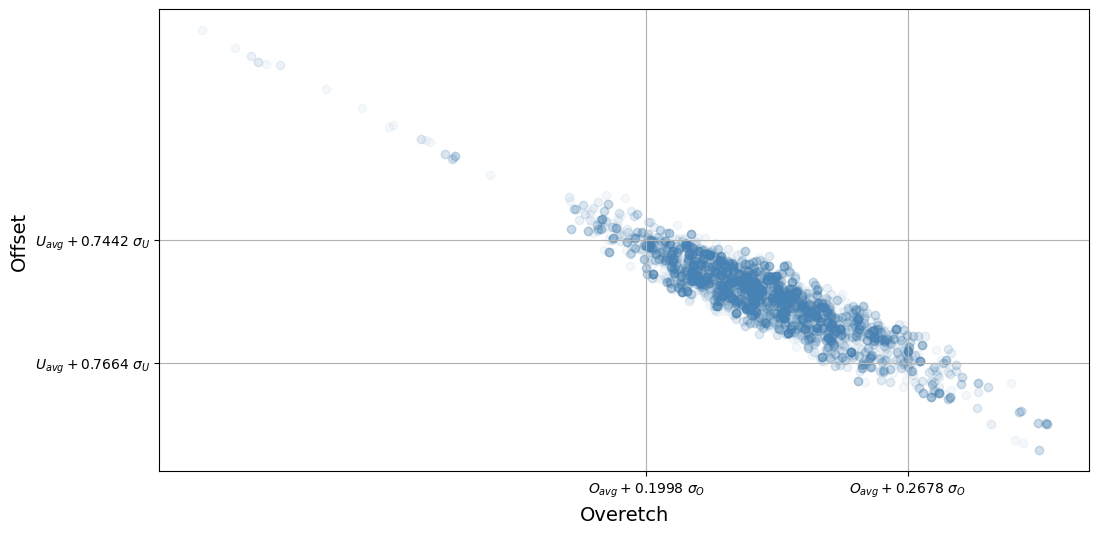

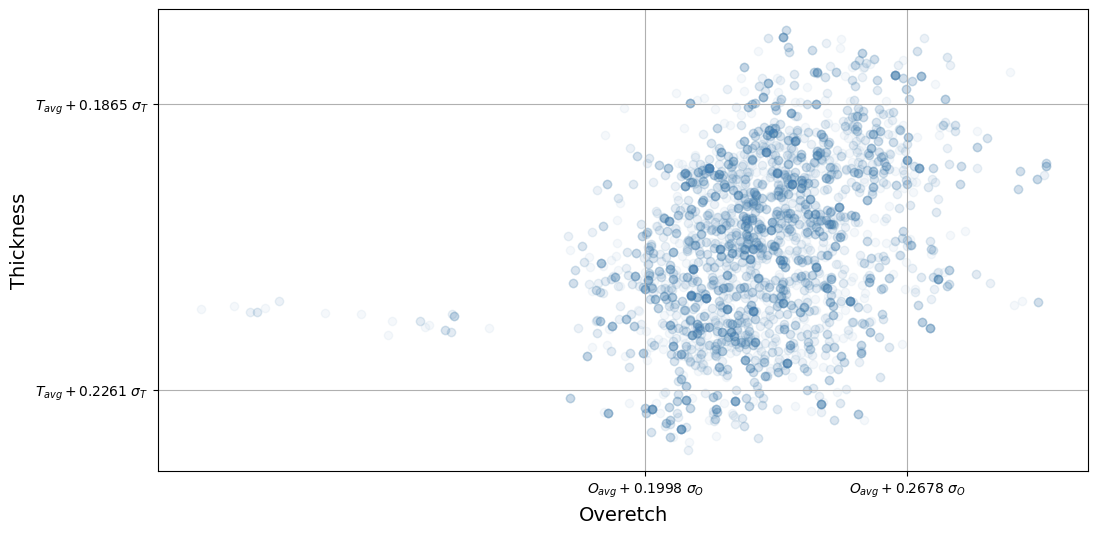

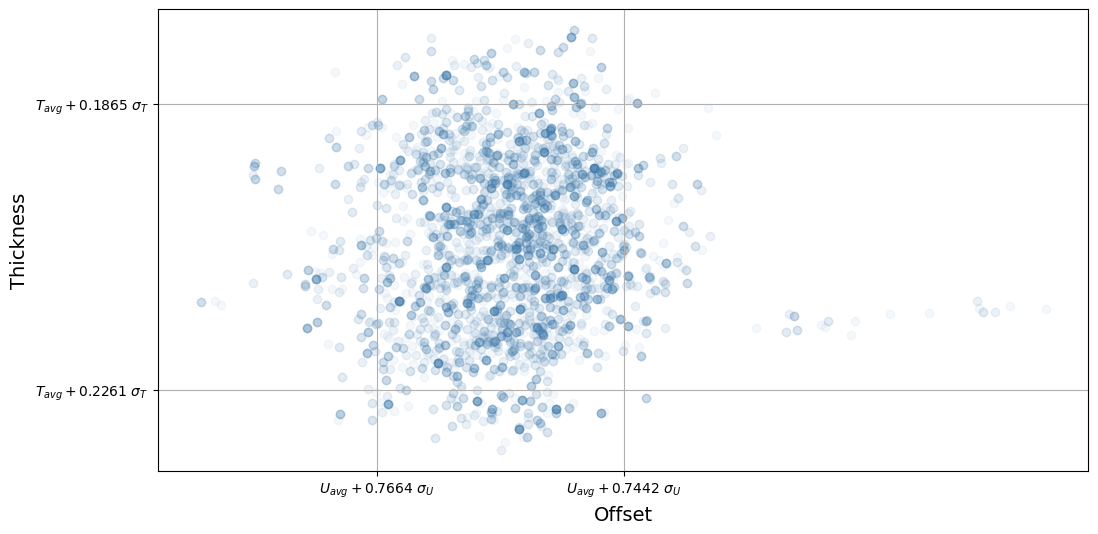

In [15]:
plot_scatter(samples)

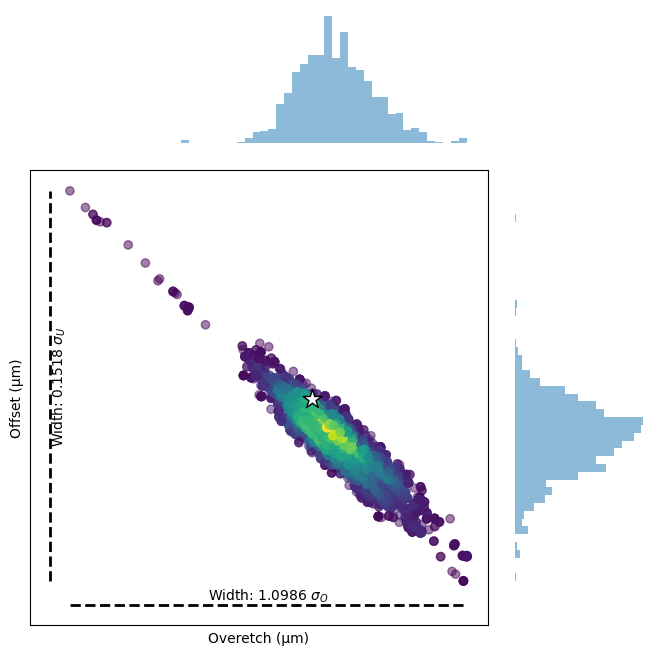

In [16]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed


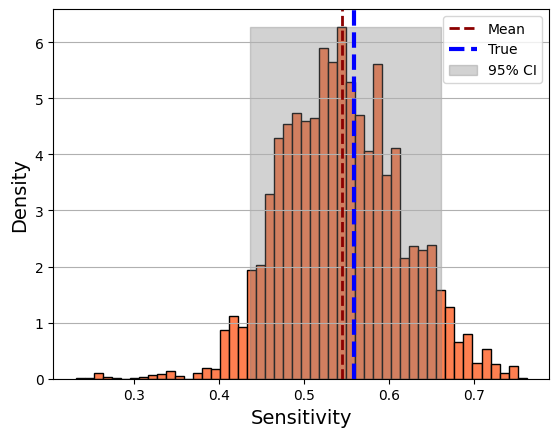

In [17]:
S_true = data_processor_II.y_test[sample]

plot_sensitivity_histogram(samples, S_true, model_II)